In [1]:
import pandas as pd
import numpy as np

from catboost import CatBoost
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score
from collections import defaultdict
from copy import copy
import multiprocessing
from gensim.models import Word2Vec
import shap

In songs dataset we haven't got duplicates

In [2]:
%%time
songs = pd.read_csv('data/songs.csv', usecols=['song_id', 'artist_name', 'genre_ids'])
len(songs['song_id'].value_counts()), songs.shape

CPU times: user 5.36 s, sys: 390 ms, total: 5.75 s
Wall time: 5.79 s


(2296320, (2296320, 3))

In [3]:
%%time
songs_extra = pd.read_csv('data/song_extra_info.csv', usecols=['song_id', 'name'])
songs_extra.head()

CPU times: user 3.14 s, sys: 312 ms, total: 3.45 s
Wall time: 3.52 s


,song_id,name
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網


Let's merge songs by their **song_id**

In [4]:
%%time
merged_songs = pd.merge(songs, songs_extra, on=['song_id', 'song_id'], how='left')
merged_songs.isnull().sum()

CPU times: user 5.24 s, sys: 362 ms, total: 5.61 s
Wall time: 5.61 s


song_id            0
genre_ids      94116
artist_name        0
name             900
dtype: int64

Drop na-name rows

In [5]:
merged_songs = merged_songs.dropna(subset=['name'])
merged_songs.isnull().sum()

song_id            0
genre_ids      94073
artist_name        0
name               0
dtype: int64

Creating new feature from song_id to **< artist_name :: song_name >**

In [6]:
%%time
def concat_artist_name(artist_name_to_song_name):
    artist, song = artist_name_to_song_name
    return '{} :: {}'.format(artist, song)

merged_songs['artist:song'] = merged_songs.loc[:, ['artist_name', 'name']].apply(concat_artist_name, axis=1)
artist_to_song = merged_songs.drop(['genre_ids', 'name', 'artist_name'], axis=1)
artist_to_song.head()

CPU times: user 16.9 s, sys: 247 ms, total: 17.1 s
Wall time: 17.1 s


,song_id,artist:song
0,CXoTN1eb7AI+DntdU1vbcwGRV4SCIDxZu+YD8JP8r4E=,張信哲 (Jeff Chang) :: 焚情
1,o0kFgae9QtnYgRkVPqLJwa05zIhRlUjfF7O1tDw0ZDU=,BLACKPINK :: PLAYING WITH FIRE
2,DwVvVurfpuz+XPuFvucclVQEyPqcpUkHR0ne1RQzPs0=,SUPER JUNIOR :: SORRY| SORRY
3,dKMBWoZyScdxSkihKG+Vf47nc18N9q4m58+b4e7dSSE=,S.H.E :: 愛我的資格
4,W3bqWd3T+VeHFzHAUfARgW9AvVRaF4N5Yzm4Mr6Eo/o=,貴族精選 :: Mary Had a Little Lamb


In [7]:
%%time
train_types = {
    'user_id'                        : 'category',
    'song_country_code'              : 'category',
    'song_registration_organisation' : 'category',
    'language'                       : 'category',
    'song_registration_year'         : 'category',
    'source_system_tab'              : 'category',
    'source_screen_name'             : 'category',
    'source_type'                    : 'category',
    
    'artist_name'                    : str,
    'genre_ids'                      : str,
    'song_id'                        : str,
    
    'target'                         : np.uint8,
}

train = pd.read_csv('data/train_processed.csv', dtype=train_types)
train.head()

CPU times: user 26.7 s, sys: 3.5 s, total: 30.2 s
Wall time: 31.9 s


,user_id,song_id,source_system_tab,source_screen_name,source_type,target,city,bd,registration_year,registration_month,...,song_length,genre_ids,artist_name,language,song_registration_year,song_country_code,song_registration_organisation,artist_count,user_genres_counter,user_artists_counter
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,1,0,2012,1,...,206471.0,359,Bastille,54,2016,GB,02854,1079,162,3
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,13,24,2011,5,...,284584.0,1259,Various Artists,54,1999,US,10183,292987,47,24
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,13,24,2011,5,...,225396.0,1259,Nas,54,2006,US,18761,276,47,2
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,13,24,2011,5,...,255512.0,1019,Soundway,1,2010,GB,00063,1,1,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,1,0,2012,1,...,187802.0,1011,Brett Young,54,2016,QM,06003,415,38,1


In [8]:
train.shape, train.dtypes

((6949045, 25),
 user_id                           category
 song_id                             object
 source_system_tab                 category
 source_screen_name                category
 source_type                       category
 target                               uint8
 city                                 int64
 bd                                   int64
 registration_year                    int64
 registration_month                   int64
 expiration_year                      int64
 expiration_month                     int64
 subscription_length                  int64
 subscription_level                   int64
 registration_method                  int64
 song_length                        float64
 genre_ids                           object
 artist_name                         object
 language                          category
 song_registration_year            category
 song_country_code                 category
 song_registration_organisation    category
 artist_count   

Drop columns according to ***SHAP values*** from previous task

In [9]:
train = train.drop(['bd', 
                    'city', 
                    'song_country_code', 
                    'language', 
                    'registration_year',
                    'registration_method',
                    'registration_month',
                    'subscription_level',
                    'expiration_year',
                    'expiration_month'], 
                   axis=1)

train.shape, train.dtypes

((6949045, 15),
 user_id                           category
 song_id                             object
 source_system_tab                 category
 source_screen_name                category
 source_type                       category
 target                               uint8
 subscription_length                  int64
 song_length                        float64
 genre_ids                           object
 artist_name                         object
 song_registration_year            category
 song_registration_organisation    category
 artist_count                         int64
 user_genres_counter                  int64
 user_artists_counter                 int64
 dtype: object)

In [10]:
train = pd.merge(train, artist_to_song, on='song_id', how='left')
train.isnull().sum()

user_id                           0
song_id                           0
source_system_tab                 0
source_screen_name                0
source_type                       0
target                            0
subscription_length               0
song_length                       0
genre_ids                         0
artist_name                       0
song_registration_year            0
song_registration_organisation    0
artist_count                      0
user_genres_counter               0
user_artists_counter              0
artist:song                       2
dtype: int64

In [11]:
train = train.dropna(subset=['artist:song'])
train.shape

(6949043, 16)

In [12]:
cat_features = ['song_registration_organisation',
                'source_system_tab',
                'artist_name',
                'genre_ids',
                'source_screen_name',         
                'source_type',
                'song_registration_year'
               ]

Prepare dataset with users liked songs for **w2v training**

In [13]:
user_to_songs = train.loc[:, ['user_id', 'song_id', 'target']]
user_to_songs.head()

,user_id,song_id,target
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,1
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,1
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,1
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,1
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,1


In [14]:
%%time
liked_songs = user_to_songs[user_to_songs['target'] == 1]
liked_songs.shape

CPU times: user 157 ms, sys: 9.64 ms, total: 166 ms
Wall time: 170 ms


(3514137, 3)

In [15]:
grouped_users = liked_songs.drop(['target'], axis=1).groupby('user_id')

In [16]:
%%time
sentences = {}

for k, frame in grouped_users:
    sentences[k] = list(map(str, frame['song_id'].to_numpy()))
sentences = [s for s in sentences.values()]

CPU times: user 5.61 s, sys: 130 ms, total: 5.74 s
Wall time: 5.92 s


Function for creating ***w2v model***

In [17]:
vector_size = 200
zeros = np.zeros(vector_size)

def get_w2v_model():    
    """
    Creates Word2Vec model.
    
    Documentation for hyperparams: https://radimrehurek.com/gensim/models/word2vec.html
    """
    cores = multiprocessing.cpu_count()
    return Word2Vec(min_count=1,
                    negative=50,
                    window=100,
                    sg=0,
                    workers=cores,
                    vector_size=vector_size)

w2v_model = get_w2v_model()

Filling model vocabulary with sentences

In [18]:
%%time
w2v_model.build_vocab(corpus_iterable=sentences)

CPU times: user 5.85 s, sys: 182 ms, total: 6.03 s
Wall time: 6.11 s


In [19]:
from gensim.models.callbacks import CallbackAny2Vec
from time import time
from datetime import timedelta

class Logger(CallbackAny2Vec):
    """
    Epoch-time logger for Word2Vec trainig status.
    """
    def __init__(self, epochs):
        self.epoch     = 1
        self.epochs    = epochs
        self.time      = time()
        self.acc_delta = 0
        
    def log_progress(self, epoch, spent, remaining):
        chop_microseconds = lambda delta: delta - timedelta(microseconds=delta.microseconds)
        total_time        = chop_microseconds(spent)
        remaining_time    = chop_microseconds(remaining)
        print("Epoch {:03d} | total time {} | remaining time: {}".format(self.epoch, total_time, remaining_time))
        
    def on_epoch_end(self, model):
        delta = time() - self.time
        self.acc_delta += delta
        remaining_time = timedelta(seconds=(self.epochs - self.epoch) * self.acc_delta / self.epoch)
        total_time     = timedelta(seconds=self.acc_delta)
        self.log_progress(self.epoch, total_time, remaining_time)

        self.time = time()
        self.epoch += 1

Let's train our ***word2vec model***

In [20]:
%%time
logger = Logger(epochs=150)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=logger.epochs, callbacks=[logger])

Epoch 001 | total time 0:00:28 | remaining time: 1:10:51
Epoch 002 | total time 0:00:54 | remaining time: 1:07:40
Epoch 003 | total time 0:01:23 | remaining time: 1:07:49
Epoch 004 | total time 0:01:51 | remaining time: 1:08:03
Epoch 005 | total time 0:02:21 | remaining time: 1:08:17
Epoch 006 | total time 0:02:51 | remaining time: 1:08:28
Epoch 007 | total time 0:03:20 | remaining time: 1:08:14
Epoch 008 | total time 0:03:49 | remaining time: 1:08:01
Epoch 009 | total time 0:04:19 | remaining time: 1:07:42
Epoch 010 | total time 0:04:48 | remaining time: 1:07:13
Epoch 011 | total time 0:05:17 | remaining time: 1:06:49
Epoch 012 | total time 0:05:45 | remaining time: 1:06:17
Epoch 013 | total time 0:06:14 | remaining time: 1:05:51
Epoch 014 | total time 0:06:43 | remaining time: 1:05:19
Epoch 015 | total time 0:07:11 | remaining time: 1:04:45
Epoch 016 | total time 0:07:40 | remaining time: 1:04:12
Epoch 017 | total time 0:08:08 | remaining time: 1:03:41
Epoch 018 | total time 0:08:36 

Epoch 145 | total time 1:08:07 | remaining time: 0:02:20
Epoch 146 | total time 1:08:36 | remaining time: 0:01:52
Epoch 147 | total time 1:09:06 | remaining time: 0:01:24
Epoch 148 | total time 1:09:35 | remaining time: 0:00:56
Epoch 149 | total time 1:10:07 | remaining time: 0:00:28
Epoch 150 | total time 1:10:38 | remaining time: 0:00:00
CPU times: user 4h 34min 35s, sys: 30.6 s, total: 4h 35min 5s
Wall time: 1h 10min 38s


(526819807, 527120550)

**Let's pick a few random songs to check training correctness**

In [105]:
from sklearn.utils import shuffle

def get_song(to_filter_by, to_show, value):
    frame = train[(train[to_filter_by] == value) & (train['target'] == 1)]
    frame = frame.drop_duplicates(subset=[to_show])
    mask  = frame['song_id'].apply(lambda song: song in w2v_model.wv).to_numpy()
    frame = frame.loc[mask, :]
    frame = shuffle(frame).reset_index()
    row   = frame.loc[0, [to_show, 'genre_ids']]
    return row[to_show], row['genre_ids']


def song_id_by_artist(name):
    """
    Returns random song for given artist.
    """
    return get_song(to_filter_by='artist_name', to_show='song_id', value=name)


def artist_song_by_id(song_id):
    """
    Returns artist for given song_id
    """
    return get_song(to_filter_by='song_id', to_show='artist:song', value=song_id)


def show_similars(artist_name=None, song_id=None):
    """
    Returns list of similars ('artist', 'genre') for random artist song.
    """
    if song_id is None:
        song_id, genre = song_id_by_artist(artist_name)
        print("random song: {}".format(artist_song_by_id(song_id)))
    
    similars = w2v_model.wv.most_similar(positive=[song_id])
    similars = list(map(artist_song_by_id, [song_id for song_id, _ in similars]))
    return similars

**Checking similars for popular artists**

In [51]:
show_similars('Linkin Park')

random song: ('Linkin Park :: Lying From You', '2022')


[('Linkin Park :: Papercut', '2022'),
 ('Linkin Park :: From The Inside', '2022'),
 ('Linkin Park :: Points Of Authority', '2022'),
 ('Linkin Park :: One Step Closer', '2022'),
 ('Linkin Park :: Numb', '2022'),
 ('Linkin Park :: In The End', '2022'),
 ('Linkin Park :: Faint', '2022'),
 ('Linkin Park :: Runaway', '2022'),
 ('Linkin Park :: Crawling', '2022'),
 ("Linkin Park :: P5hng Me A'wy", '2022')]

In [43]:
show_similars('Eminem')

random song: ('Eminem :: Ass Like That', '1259')


[('Eminem :: Love Me', '1259'),
 ('Eminem :: Music Box (音樂盒)', '1259'),
 ('Eminem :: Puke', '1259'),
 ('Eminem :: Love You More', '1259'),
 ('Eminem :: As The World Turns', '1259'),
 ('Eminem :: Infinite', '1259'),
 ('Eminem :: Shit On You', '1259'),
 ('Eminem :: We As Americans', '1259'),
 ("Eminem :: Old Time's Sake (feat. Dr. Dre) (老友記 阿姆+德瑞博士攜手直奔iTunes排行榜亞軍曲)",
  '1259'),
 ('Eminem :: My Fault', '1259')]

In [57]:
show_similars('Justin Bieber')

random song: ('Justin Bieber :: Runaway Love', '465')


[('Justin Bieber :: Somebody To Love', '465'),
 ('Pitbull :: Hey Baby (Drop It To The Floor)', '465'),
 ('Justin Timberlake :: Let the Groove Get In', '465'),
 ('Damon Albarn :: Everyday Robots', '359'),
 ('Justin Bieber :: U Smile', '465'),
 ('Justin Bieber :: One Time', '465'),
 ('Justin Bieber :: Somebody To Love', '465'),
 ('Mohombi :: Match Made In Heaven', '465'),
 ('Justin Bieber :: Favorite Girl', '465'),
 ('Justin Bieber :: Stuck In The Moment', '465')]

In [88]:
show_similars('Michael Jackson')

random song: ('Michael Jackson :: Billie Jean', '465')


[('Michael Jackson :: The Lady in My Life', '465'),
 ('Michael Jackson :: Baby Be Mine', '465'),
 ('Michael Jackson :: The Way You Make Me Feel', '465'),
 ('Michael Jackson :: Voice-Over Intro Rod Temperton Interview #1 / Rod Temperton Interview #1',
  '465'),
 ('Michael Jackson :: Thriller', '465'),
 ('Michael Jackson :: Voice-Over Intro / Voice-Over Session from Thriller',
  '465'),
 ("Michael Jackson :: Wanna Be Startin' Somethin'", '465'),
 ('Michael Jackson :: Jam', '465'),
 ('Michael Jackson :: Quincy Jones Interview #4', '465'),
 ('Michael Jackson :: Smooth Criminal', '465')]

In [156]:
show_similars('Bob Marley')

random song: ('Bob Marley :: I Shot the Sheriff', '1180')


[('Bob Marley :: Them Belly Full (But We Hungry)', '1180'),
 ('Bob Marley :: Crazy Bald Head', '1180'),
 ('Bob Marley :: Wake up and Live', '1180'),
 ('Bob Marley :: War No More Trouble', '1180'),
 ('Bob Marley :: Ambush in the Night', '1180'),
 ('Bob Marley :: Concrete Jungle', '1180'),
 ('Bob Marley :: The Heathen', '1180'),
 ('Bob Marley :: Positive Vibration', '1180'),
 ('Bob Marley :: Riding High', '465'),
 ('Bob Marley :: My Cup', '465')]

**Axiluary functions for getting embeddings**

In [32]:
def get_song_embedding(song):
    if song in w2v_model.wv:
        return w2v_model.wv[song]
    else:
        return zeros
    
def get_user_embedding(user):
    return user_embeddings.get(user)

Let's create ***user-emberdding vectors***

In [33]:
%%time

def get_user_embeddings(vector_size=vector_size):
    user_embed = {}
        
    for i, (user, _) in enumerate(grouped_users):
        songs_embeddings = list(map(get_song_embedding, sentences[i]))
        n                = len(songs_embeddings)
        if n == 0:
            user_embed[user] = zeros
        else:
            user_embed[user] = np.array(songs_embeddings).mean(axis=0)
            
    return user_embed

        
user_embeddings = get_user_embeddings()

CPU times: user 15.5 s, sys: 256 ms, total: 15.8 s
Wall time: 17.1 s


In [34]:
def dot_embeddings(user_to_song):
    user, song = user_to_song
    user_emb   = get_user_embedding(user)
    song_emb   = get_song_embedding(song)
    return user_emb @ song_emb

Calculating dot product for user-song embeddings

In [35]:
%%time
w2v_predictions = train.loc[:, ['user_id', 'song_id']].apply(dot_embeddings, axis=1)

CPU times: user 1min 35s, sys: 1.7 s, total: 1min 36s
Wall time: 1min 38s


Calculating ***ROC AUC*** score for ***user-song embeddings dot product*** and ***target-values***

In [36]:
roc_auc_score(train.target, w2v_predictions)

0.730900929453246

Let's make staking with ***CatBoost*** model

In [59]:
def get_model(iterations=300):    
    """
    Creates custom CatBoost model.
    
    Documentation for hyperpararms: https://catboost.ai/docs/concepts/speed-up-training.html
    """
    params = {
      'loss_function'              : 'Logloss',
      'custom_metric'              : 'AUC',
      'train_dir'                  : 'train_log',
      'max_ctr_complexity'         : 1, 
      'leaf_estimation_iterations' : 1,
      'learning_rate'              : 0.1,
      'iterations'                 : iterations    
    }
    return CatBoost(params=params)

In [60]:
def drop_user_id(X):
    return X.drop(['user_id'], axis=1)

def split_users(X, y, k):
    X['is_test'] = X['user_id'].apply(lambda x: hash(x) % 1000 < 1000 // k)
     
    test_mask  = X['is_test'] == True
    train_mask = X['is_test'] == False
    X.drop(['is_test'], axis=1, inplace=True)
    
    return drop_user_id(X[train_mask]), y[train_mask], drop_user_id(X[test_mask]), y[test_mask]

In [61]:
def k_fold_per_user(X, y, iterations=300, k=5):
    """
    returns: (aucs, models)
    """
    aucs, models = [], []    
    
    for i in range(k):
        print('Fold {} / {}'.format(i + 1, k))
        model = get_model(iterations=iterations)
        
        X_train, y_train, X__test, y__test = split_users(X, y, k)
        
        X__test, X_eval, y__test, y_eval = train_test_split(X__test, 
                                                            y__test, 
                                                            test_size=0.1,
                                                            shuffle=True)
        
        log_freq = iterations // 20 if iterations > 20 else 3
        
        model.fit(X_train, 
                  y_train,
                  cat_features=cat_features,
                  eval_set=(X_eval, y_eval),
                  metric_period=log_freq,
                  use_best_model=True,
                  verbose=True
                 )
        
        models.append(model)
    
        predicted = model.predict(X__test)
        auc = roc_auc_score(y__test, predicted)
        
        aucs.append(auc)
        print("AUC: {:07f}{}".format(auc, '\n~~~~~~\n'))
        
    return aucs, models

In [62]:
train['w2v_predictions'] = w2v_predictions
train.head()

,user_id,song_id,source_system_tab,source_screen_name,source_type,target,subscription_length,song_length,genre_ids,artist_name,song_registration_year,song_registration_organisation,artist_count,user_genres_counter,user_artists_counter,artist:song,w2v_predictions
0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,2103,206471.0,359,Bastille,2016,02854,1079,162,3,Bastille :: Good Grief,30.909391
1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,2301,284584.0,1259,Various Artists,1999,10183,292987,47,24,Various Artists :: Lords of Cardboard,51.369663
2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,2301,225396.0,1259,Nas,2006,18761,276,47,2,Nas :: Hip Hop Is Dead(Album Version (Edited)),49.093010
3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,2301,255512.0,1019,Soundway,2010,00063,1,1,1,Soundway :: Disco Africa,46.388298
4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,2103,187802.0,1011,Brett Young,2016,06003,415,38,1,Brett Young :: Sleep Without You,76.546799


In [70]:
X = train.drop(['target', 'song_id', 'artist:song'], axis=1)
y = train.target

In [89]:
%%time
aucs, models = k_fold_per_user(X=X, 
                               y=y,
                               iterations=250)

Fold 1 / 5
0:	learn: 0.6730634	test: 0.6726904	best: 0.6726904 (0)	total: 3.24s	remaining: 13m 26s
12:	learn: 0.5796768	test: 0.5776981	best: 0.5776981 (12)	total: 17.2s	remaining: 5m 14s
24:	learn: 0.5603558	test: 0.5583774	best: 0.5583774 (24)	total: 29.8s	remaining: 4m 28s
36:	learn: 0.5515379	test: 0.5494865	best: 0.5494865 (36)	total: 42.3s	remaining: 4m 3s
48:	learn: 0.5465595	test: 0.5445400	best: 0.5445400 (48)	total: 53.9s	remaining: 3m 41s
60:	learn: 0.5435289	test: 0.5417785	best: 0.5417785 (60)	total: 1m 5s	remaining: 3m 22s
72:	learn: 0.5409661	test: 0.5392429	best: 0.5392429 (72)	total: 1m 16s	remaining: 3m 6s
84:	learn: 0.5390018	test: 0.5373301	best: 0.5373301 (84)	total: 1m 28s	remaining: 2m 52s
96:	learn: 0.5374576	test: 0.5360935	best: 0.5360935 (96)	total: 1m 40s	remaining: 2m 38s
108:	learn: 0.5361491	test: 0.5348964	best: 0.5348964 (108)	total: 1m 52s	remaining: 2m 25s
120:	learn: 0.5348426	test: 0.5337811	best: 0.5337811 (120)	total: 2m 4s	remaining: 2m 12s
132:	

AUC: 0.804372
~~~~~~

Fold 5 / 5
0:	learn: 0.6730634	test: 0.6729527	best: 0.6729527 (0)	total: 2.72s	remaining: 11m 16s
12:	learn: 0.5796768	test: 0.5797430	best: 0.5797430 (12)	total: 15.7s	remaining: 4m 46s
24:	learn: 0.5603558	test: 0.5609202	best: 0.5609202 (24)	total: 27.8s	remaining: 4m 10s
36:	learn: 0.5515379	test: 0.5524090	best: 0.5524090 (36)	total: 39.6s	remaining: 3m 47s
48:	learn: 0.5465595	test: 0.5475989	best: 0.5475989 (48)	total: 51.1s	remaining: 3m 29s
60:	learn: 0.5435289	test: 0.5449459	best: 0.5449459 (60)	total: 1m 2s	remaining: 3m 13s
72:	learn: 0.5409661	test: 0.5425076	best: 0.5425076 (72)	total: 1m 14s	remaining: 3m
84:	learn: 0.5390018	test: 0.5406840	best: 0.5406840 (84)	total: 1m 26s	remaining: 2m 47s
96:	learn: 0.5374576	test: 0.5394736	best: 0.5394736 (96)	total: 1m 38s	remaining: 2m 34s
108:	learn: 0.5361491	test: 0.5382747	best: 0.5382747 (108)	total: 1m 49s	remaining: 2m 21s
120:	learn: 0.5348426	test: 0.5372271	best: 0.5372271 (120)	total: 2m 1s	rem

In [90]:
aucs

[0.8038116518341354,
 0.8040480234035209,
 0.804241728046194,
 0.8043723772026661,
 0.8042114774627165]

**Hooray ! ! !    
*AUC* increased by 10%** from naive GBDT

**SHAP values**

In [91]:
def explain_shap_values(X, y, model):
    _, X_test, _, _ = train_test_split(drop_user_id(X), y, test_size=0.2, shuffle=True)
    shap_values = shap.TreeExplainer(model).shap_values(X_test)
    shap.summary_plot(shap_values, X_test, max_display=X_test.shape[1])

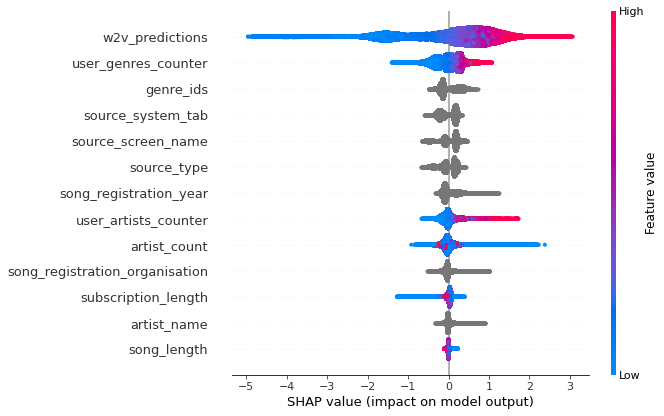

CPU times: user 6min 57s, sys: 6.9 s, total: 7min 4s
Wall time: 3min 5s


In [92]:
%%time
explain_shap_values(X, y, models[0])